This code is for EN5423 class at GIST, Republic of Korea, and created by Dr. Hyunglok Kim.  
**Contact information**: hyunglokkim@gist.ac.kr  
**License**: This work is licensed for non-commercial use only.  
**Restrictions**: Do not use this material without permission for teaching or developing other classes.

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
import statsmodels.api as sm

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Exercise 1: Evaluating Linearity

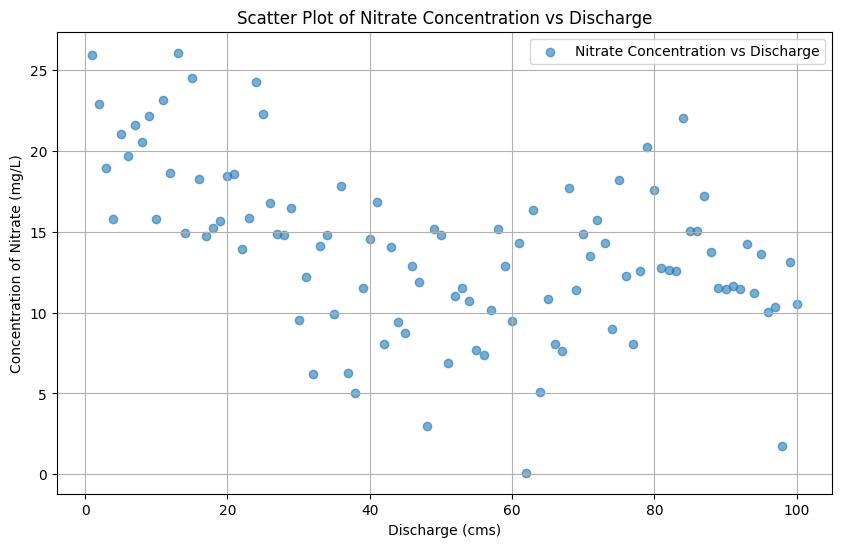

In [20]:
x = np.linspace(1, 100, 100)  # Discharge
y = 20 - np.log(x) * 2 + np.sin(x/10) * 3

# Adding random noise
noise = np.random.normal(0, 4, x.shape)
y_noisy = y + noise

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y_noisy, alpha=0.6, label='Nitrate Concentration vs Discharge')
plt.title('Scatter Plot of Nitrate Concentration vs Discharge')
plt.xlabel('Discharge (cms)')
plt.ylabel('Concentration of Nitrate (mg/L)')
plt.legend()
plt.grid(True)
plt.show()

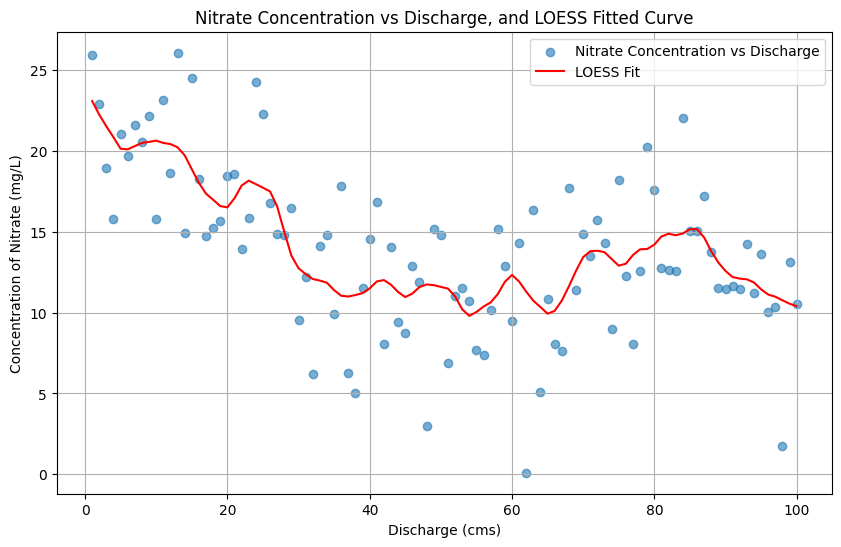

In [26]:

# Lowess smoothing (Locally Weighted Scatterplot Smoothing)
lowess = sm.nonparametric.lowess
y_lowess = lowess(y_noisy, x, frac=0.1)[:, 1]  # frac is the fraction of data points used for smoothing

# Plotting the scatter plot with LOESS fitting
plt.figure(figsize=(10, 6))
plt.scatter(x, y_noisy, alpha=0.6, label='Nitrate Concentration vs Discharge')
plt.plot(x, y_lowess, color='red', label='LOESS Fit')
plt.title('Nitrate Concentration vs Discharge, and LOESS Fitted Curve')
plt.xlabel('Discharge (cms)')
plt.ylabel('Concentration of Nitrate (mg/L)')
plt.legend()
plt.grid(True)
plt.show()

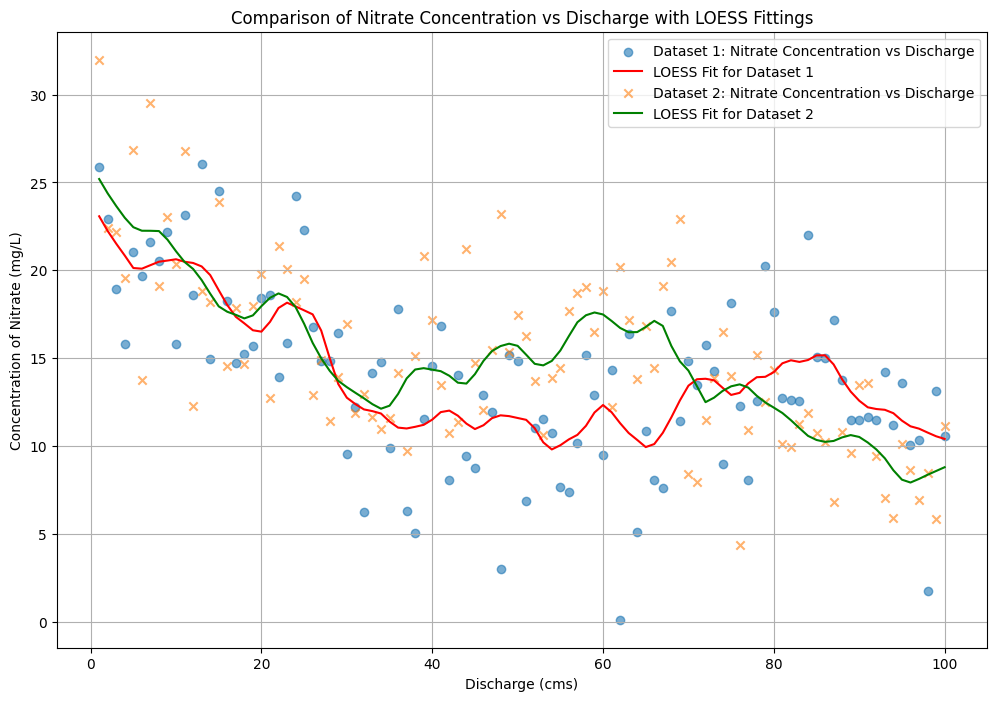

In [25]:
# Generating a second fake data set for concentration of nitrate vs discharge with a different pattern
np.random.seed(1)  # Changing seed for different noise
x2 = np.linspace(1, 100, 100)  # Discharge for second dataset
y2 = 25 - np.sqrt(x2) * 1.5 + np.cos(x2/10) * 2  # Different concave shape with more variation

# Adding random noise to the second dataset
noise2 = np.random.normal(0, 4, x2.shape)
y2_noisy = y2 + noise2

# Applying LOESS to both datasets
y_lowess1 = lowess(y_noisy, x, frac=0.1)[:, 1]  # For the first dataset
y_lowess2 = lowess(y2_noisy, x2, frac=0.1)[:, 1]  # For the second dataset

# Plotting the scatter plots with LOESS fittings for both datasets
plt.figure(figsize=(12, 8))
plt.scatter(x, y_noisy, alpha=0.6, label='Dataset 1: Nitrate Concentration vs Discharge')
plt.plot(x, y_lowess1, color='red', label='LOESS Fit for Dataset 1')
plt.scatter(x2, y2_noisy, alpha=0.6, marker='x', label='Dataset 2: Nitrate Concentration vs Discharge')
plt.plot(x2, y_lowess2, color='green', label='LOESS Fit for Dataset 2')
plt.title('Comparison of Nitrate Concentration vs Discharge with LOESS Fittings')
plt.xlabel('Discharge (cms)')
plt.ylabel('Concentration of Nitrate (mg/L)')
plt.legend()
plt.grid(True)
plt.show()

### Exercise 2: Evaluating Differences in Central Tendency on a Scatterplot

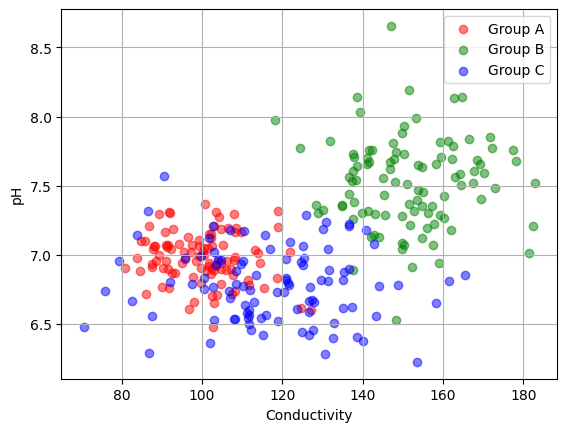

In [8]:
# Set seed for reproducibility
np.random.seed(42)

# Generating random data for three different groups
group_data = {
    'Group A': {'pH': np.random.normal(7.0, 0.2, 100), 'Conductivity': np.random.normal(100, 10, 100)},
    'Group B': {'pH': np.random.normal(7.5, 0.3, 100), 'Conductivity': np.random.normal(150, 15, 100)},
    'Group C': {'pH': np.random.normal(6.8, 0.25, 100), 'Conductivity': np.random.normal(120, 20, 100)},
}

# Plotting
fig, ax = plt.subplots()

colors = ['red', 'green', 'blue']
for (group, color) in zip(group_data.keys(), colors):
    ax.scatter(group_data[group]['Conductivity'], group_data[group]['pH'], color=color, alpha=0.5, label=group)

ax.set_xlabel('Conductivity')
ax.set_ylabel('pH')
ax.legend()
plt.grid()
plt.show()

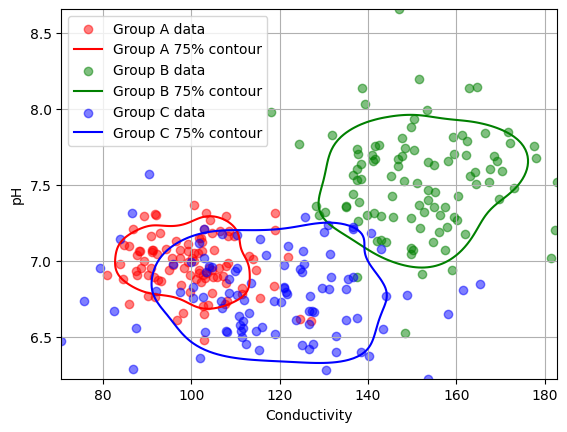

In [13]:
def draw_corrected_density_contour(ax, x, y, coverage=0.75, color='red', label=''):
    # Create a grid of points
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    
    # Compute KDE
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    
    # Total sum of KDE
    total_kde_sum = Z.sum()
    
    # Sort Z values to find the threshold for the desired coverage
    sorted_Z = np.sort(Z.ravel())
    cumulative_Z = np.cumsum(sorted_Z)
    
    # Find the level where the sum is just over the threshold for desired coverage
    threshold = cumulative_Z[-1] * coverage
    cutoff_idx = np.where(cumulative_Z >= threshold)[0][0]
    cutoff_value = sorted_Z[cutoff_idx]

    # Contour at the level that cuts off the desired coverage
    contour = ax.contour(X, Y, Z, levels=[cutoff_value], colors=color)
    
    # Creating a legend with the label, since contour labels are tricky
    ax.plot([], [], color=color, label=label)

# Plotting the original data points with corrected density contours
fig, ax = plt.subplots()

for (group, color) in zip(group_data.keys(), colors):
    x = group_data[group]['Conductivity']
    y = group_data[group]['pH']
    ax.scatter(x, y, color=color, alpha=0.5, label=f"{group} data")
    draw_corrected_density_contour(ax, x, y, coverage=0.30, color=color, label=f"{group} 75% contour")

ax.set_xlabel('Conductivity')
ax.set_ylabel('pH')
plt.grid()
ax.legend()
plt.show()

### Exercise 3: Evaluating Differences in Spread

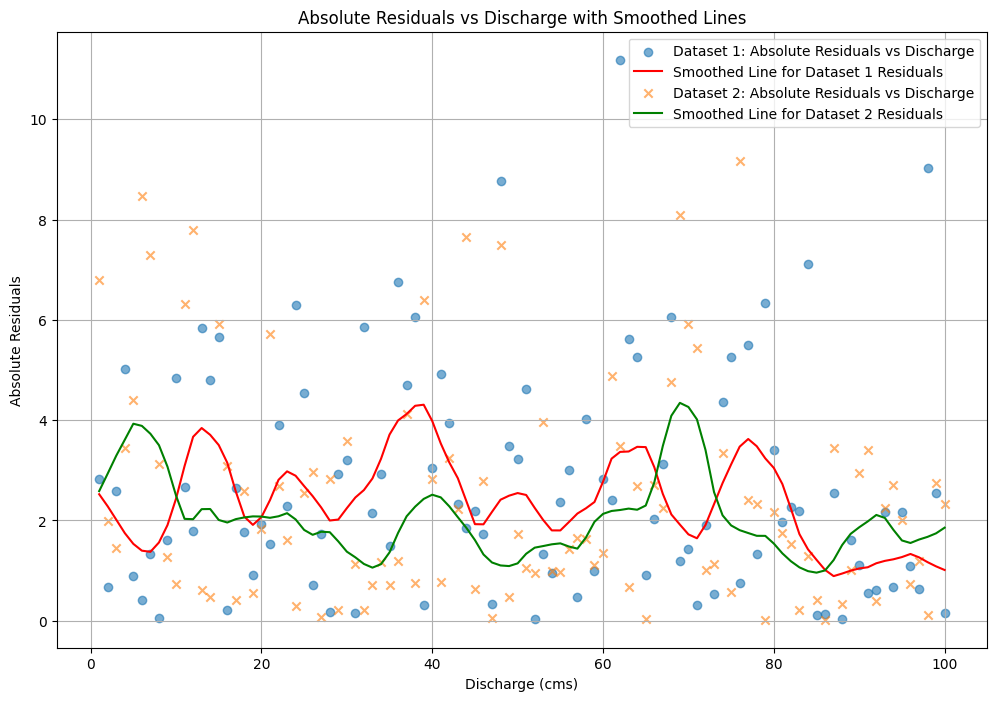

In [29]:
# Calculating the absolute residuals (d) for both datasets from the smoothed (LOESS) lines
d1 = np.abs(y_lowess1 - y_noisy)  # Absolute residuals for the first dataset
d2 = np.abs(y_lowess2 - y2_noisy)  # Absolute residuals for the second dataset

# Plotting the scatter plots of absolute residuals vs discharge for both datasets
plt.figure(figsize=(12, 8))

# Dataset 1
plt.scatter(x, d1, alpha=0.6, label='Dataset 1: Absolute Residuals vs Discharge')
# Plotting a smoothed line for the residuals of Dataset 1
d1_smoothed = lowess(d1, x, frac=0.1)[:, 1]
plt.plot(x, d1_smoothed, color='red', label='Smoothed Line for Dataset 1 Residuals')

# Dataset 2
plt.scatter(x2, d2, alpha=0.6, marker='x', label='Dataset 2: Absolute Residuals vs Discharge')
# Plotting a smoothed line for the residuals of Dataset 2
d2_smoothed = lowess(d2, x2, frac=0.1)[:, 1]
plt.plot(x2, d2_smoothed, color='green', label='Smoothed Line for Dataset 2 Residuals')

plt.title('Absolute Residuals vs Discharge with Smoothed Lines')
plt.xlabel('Discharge (cms)')
plt.ylabel('Absolute Residuals')
plt.legend()
plt.grid(True)
plt.show()

# HW3 #4: Analyzing Seasonal Variations in River Nitrate Concentrations

## Objective

Investigate how nitrate concentrations and discharge rates vary between cold and warm seasons in the Iowa Wapello region, utilizing statistical analysis and visualization techniques to uncover potential environmental impacts.

## Datasets

- `IowaWapNO23.cold.csv` - Cold season data for nitrate concentration and discharge.
- `IowaWapNO23.warm.csv` - Warm season data for nitrate concentration and discharge.

## Tasks

### Data Loading and Preprocessing
- Load both the cold and warm season datasets into separate pandas DataFrames.
- Perform a preliminary analysis to check for missing values and understand the data structure (columns: `DecYear`, `Month`, `Conc`, `Q`).

### Exploratory Data Analysis (EDA)
- Generate summary statistics for each dataset to understand the distribution of nitrate concentrations and discharge rates.
- Plot histograms for nitrate concentrations and discharge rates for both seasons to visually inspect their distributions.

### Seasonal Comparison of Nitrate Concentrations and Discharge
- Create scatter plots for both datasets, with nitrate concentration on the y-axis and discharge on the x-axis. Use different colors or markers to distinguish between seasons.
- Apply LOESS fitting to each scatter plot to model the relationship between nitrate concentration and discharge for both seasons.

### Analysis of Residuals
- Calculate the absolute residuals from the LOESS smoothed lines for both datasets.
- Create a scatter plot of these residuals against discharge, again distinguishing between seasons. Apply a LOESS fit to the residuals to explore any patterns.

## Discussion Questions
- Based on the LOESS models and residual analysis, describe the seasonal differences in the relationship between nitrate concentration and discharge. What environmental factors could explain these differences?
- Discuss how agricultural practices, precipitation patterns, and other anthropogenic or natural factors might influence seasonal variations in nitrate concentrations.
- Reflect on the potential ecological and water quality implications of your findings. How might these seasonal variations affect aquatic life and water resource management in the Iowa Wapello region?


In [37]:
base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive/'
FP = base_FP + '/GIST/0.Lectures/2024_Spring/EN5423/datasets/week03/'
input_file_cold = 'IowaWapNO23.cold.csv'
input_file_warm = 'IowaWapNO23.warm.csv'

# Load the provided CSV file into a pandas DataFrame
file_path_cold = FP+input_file_cold
df_cold = pd.read_csv(file_path_cold)

file_path_warm = FP+input_file_warm
df_warm = pd.read_csv(file_path_warm)

# Display the first few rows of the DataFrame to understand its structure and contents
df_cold.head()

,DecYear,Month,Conc,Q
0,1990.195890,3,8.8,322.812049
1,1991.171233,3,5.5,767.386537
2,1991.297260,4,11.0,866.495499
3,1992.168033,3,7.2,362.455634
4,1993.204110,3,2.6,438.911119


### Excersize 4: Scatterplot Matrix

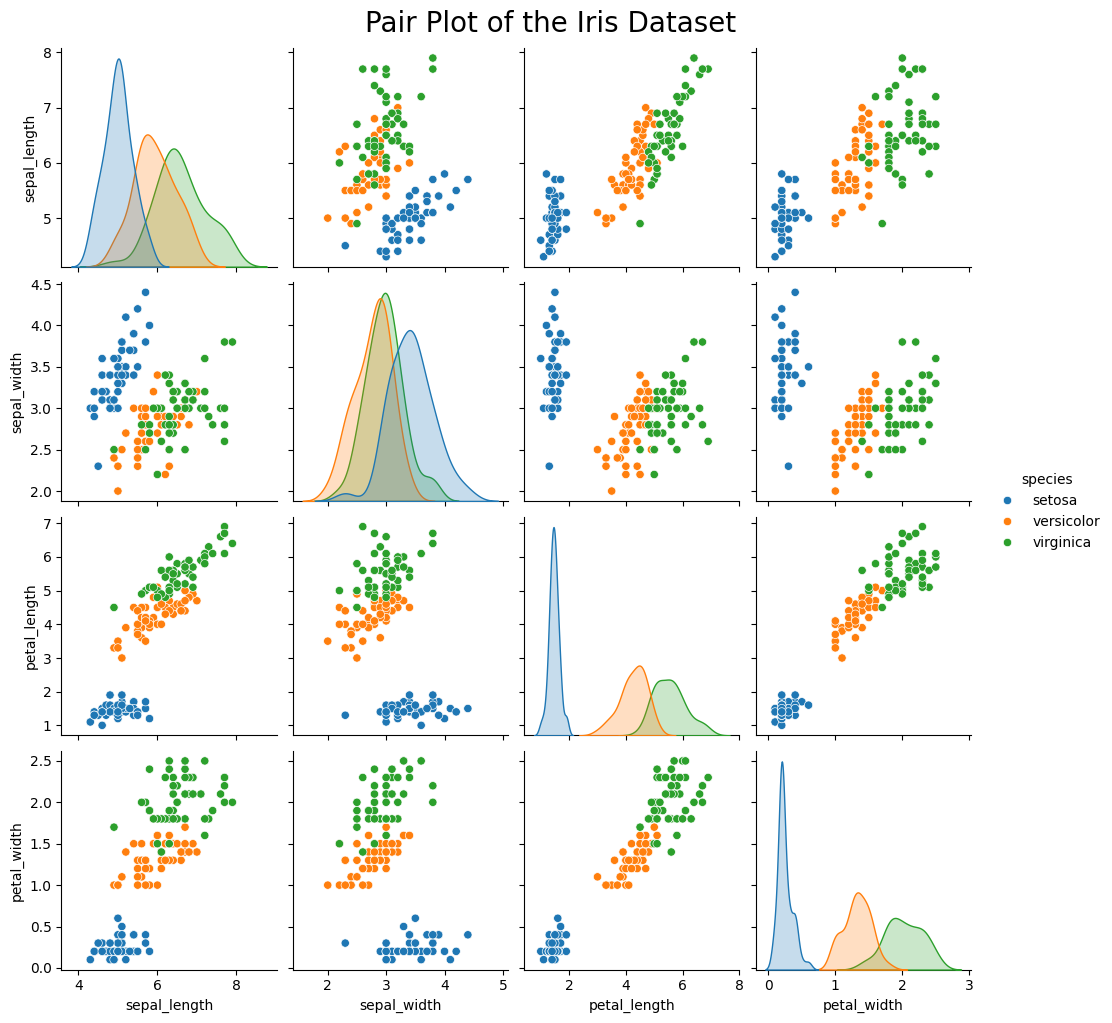

In [39]:
# Load the Iris dataset
iris = sns.load_dataset('iris')

# Create a pair plot
sns.pairplot(iris, hue='species')

# Enhance plot readability
plt.suptitle('Pair Plot of the Iris Dataset', size=20, y=1.02)
plt.show()

### Exercise 4: Biplots of Principal Components 

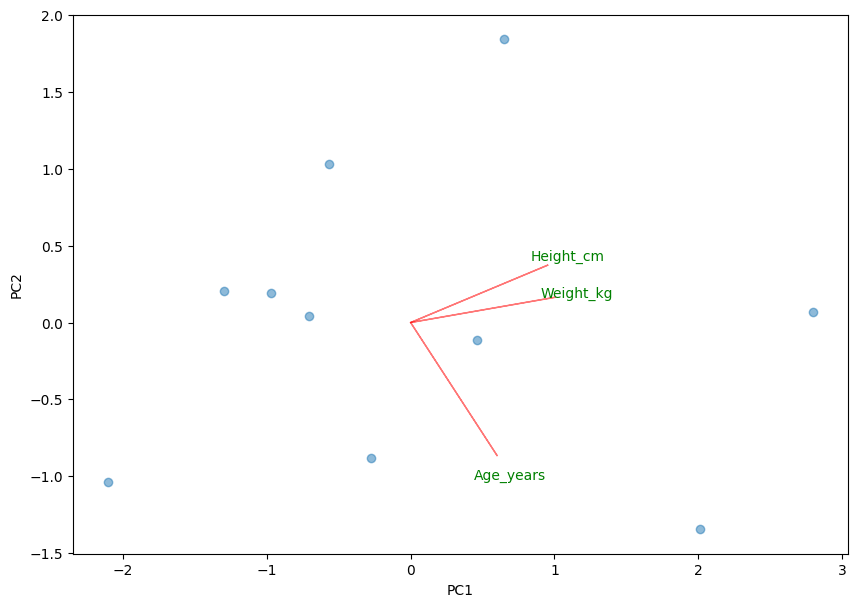

In [41]:
# Advanced (PCA example)
# Example data
data = {
    'Height_cm': [172, 168, 177, 181, 172, 165, 174, 169, 183, 180],
    'Weight_kg': [68, 74, 72, 77, 66, 59, 71, 67, 88, 78],
    'Age_years': [29, 33, 32, 24, 28, 31, 25, 27, 35, 40]
}

# Creating DataFrame
df = pd.DataFrame(data)

X = StandardScaler().fit_transform(df)  # Standardize the data

pca = PCA(n_components=2)
components = pca.fit_transform(X)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

plt.figure(figsize=(10, 7))
plt.scatter(components[:, 0], components[:, 1], alpha=0.5)
for i, varname in enumerate(df.columns):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='r', alpha=0.5)
    plt.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, varname, color='g', ha='center', va='center')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()